<a href="https://colab.research.google.com/github/bhupathi-20/FMML_projects_and_labs/blob/main/AIML_Module_4_Lab_2_Introduction_to_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Perceptron and Gradient Descent
## Lab 2: Introduction to Gradient Descent

Gradient descent is a very important algorithm to understand, as it underpins many of the more advanced algorithms used in Machine Learning and Deep Learning.

A brief overview of the algorithm is


*   start with a random initialization of the solution.
*   incrementally change the solution by moving in the direction of negative gradient of the objective function.
*   repeat the previous step until some convergence criteria is met.

The key equation for change in weight is:
$$w^{k+1} \leftarrow w^k - \eta \Delta J$$



In [98]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

We can start be choosing coefficients for a second degree polynomial equation $(a x^2 + bx + c)$ that will distribute the data we will try to model.

Let's define some random x data (inputs) we hope to predict y (outputs) of.

In [99]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [1, 0, 0]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

In [100]:
len(xs)

100

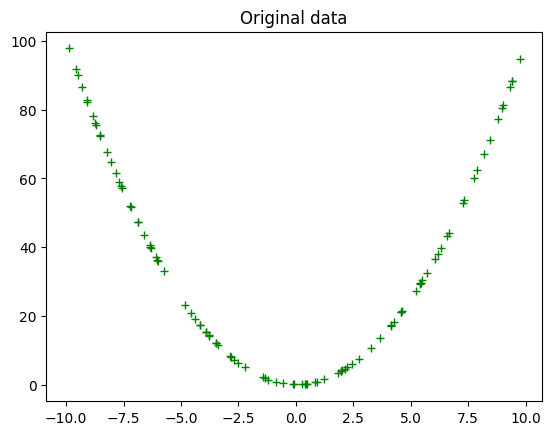

In [101]:
plt.plot(xs, ys, 'g+')
plt.title('Original data')
plt.show()

This is good, but we could improve on this by making things more realistic. You can add noise or **jitter** to the values so they can resemble real-world data.


In [102]:
def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


In [103]:
for x in hundred_xs[:5]:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    print(y)

6.257730595848507
81.28635133441196
21.61273710988859
3.813475926195647
47.32444156165738


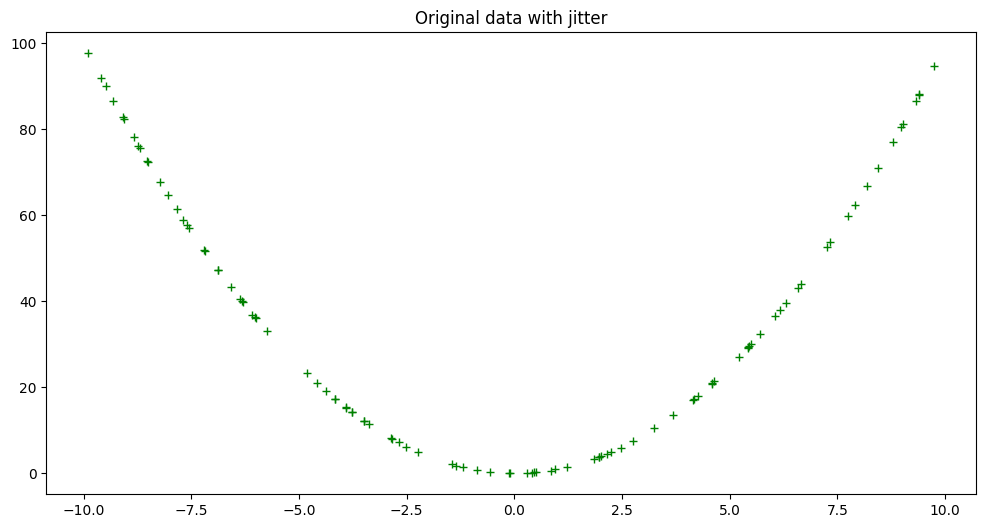

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

We will now build our predictive model, and optimize it with gradient descent and we will try to get as close to these values as possible.

To get a quantifiable measure of how incorrect it is, we calculate the Mean Squared Error loss for the model. This is the mean value of the sum of the squared differences between the actual and predicted outputs.

$$ E = \frac{1}{n} \sum_{i=0}^n (y_i - \bar{y_i})^2 $$

In [105]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

(7, 4, 6)


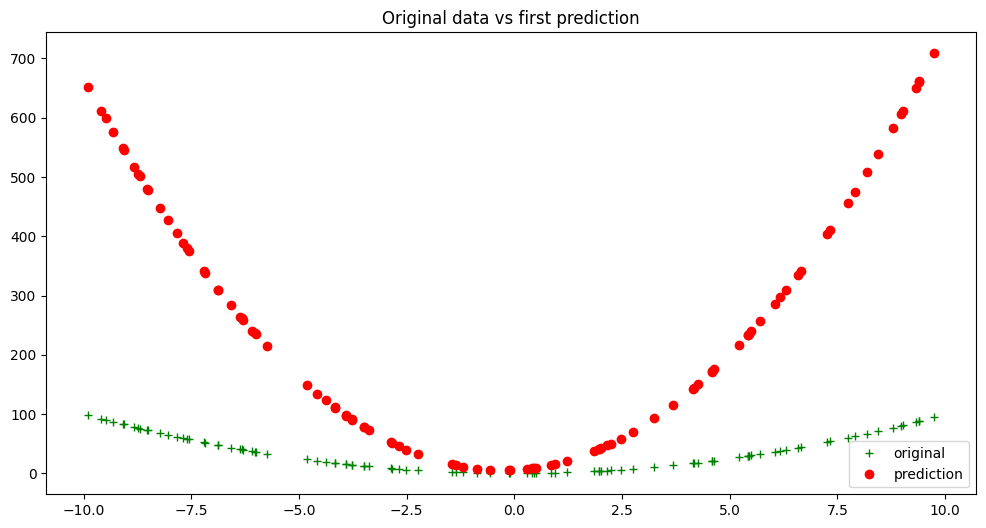

In [106]:
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
print(rand_coeffs)
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [107]:
initial_model_loss = loss_mse(ys, y_bar)
initial_model_loss

78033.29867576344

We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

In [108]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

In [109]:
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

lr = 0.0001
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]

new_model_coeffs = (a_new, b_new, c_new)
print(f"New model coeffs: {new_model_coeffs}")

# update with these new coeffs:
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (4.428816841676018, 4.020070990314525, 5.956792850037195)
Now have smaller model loss: 26018.459845237554 vs 78033.29867576344


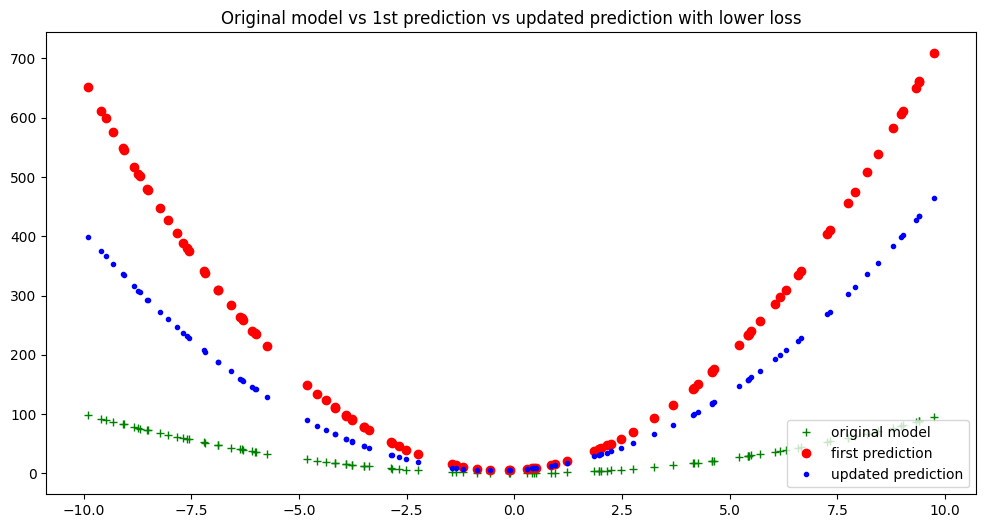

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original model')
plt.plot(xs, y_bar, 'ro', label = 'first prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [111]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [112]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

In [113]:
GD = gradient_descent(30000, 0.0003)

[6694.901367570988, 1040.1543155647319, 573.1091145951359, 516.5632752154281, 493.2421011552934, 473.32016646171263, 454.4103420087894, 436.2935239525276, 418.92306938008966, 402.26716134145556, 386.2963112577075, 370.98232439512526, 356.2981724998392, 342.21793994723936, 328.7167774985481, 315.77085838590347, 303.35733623801747, 291.4543047397244, 280.0407589516132, 269.09655822125535, 258.6023906205201, 248.53973884618142, 238.89084752360762, 229.63869185580094, 220.76694756243106, 212.25996205578204, 204.10272680271825, 196.2808508238685, 188.78053528323446, 181.5885491233586, 174.69220570302554, 168.0793403962498, 161.73828911299526, 155.6578677036975, 149.82735221122655, 144.2364599354189, 138.8753312767438, 133.73451232704554, 128.80493817662315, 124.07791690816856, 119.5451142493065, 115.19853885663245, 111.0305282052658, 107.03373505900502, 103.20111449719134, 99.52591147537761, 96.00164889783584, 92.62211618084295, 89.38135828655258, 86.27366520808735, 83.29356188728653, 80.43

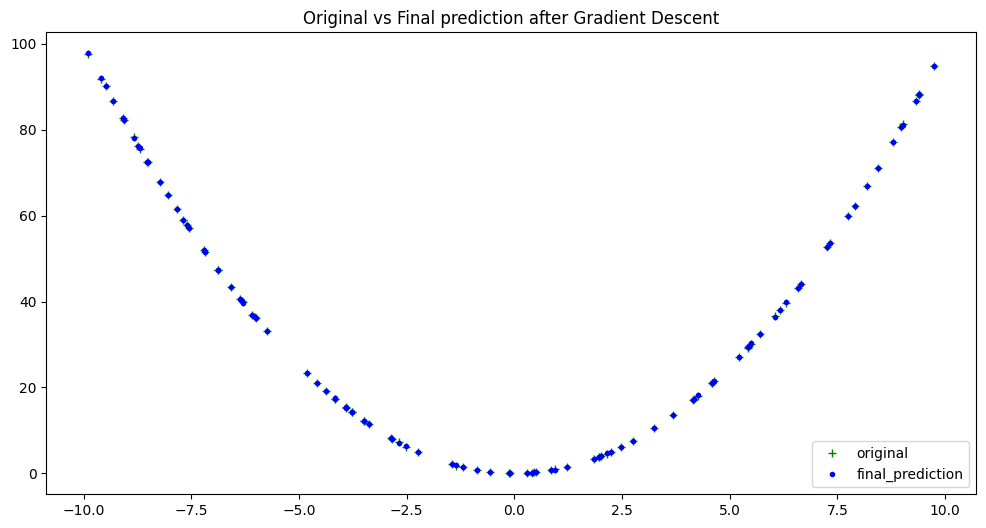

In [114]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [115]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (0.999851042438626, -0.002879473261029097, -0.006350207152481951)
Original Coefficients: [1, 0, 0]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


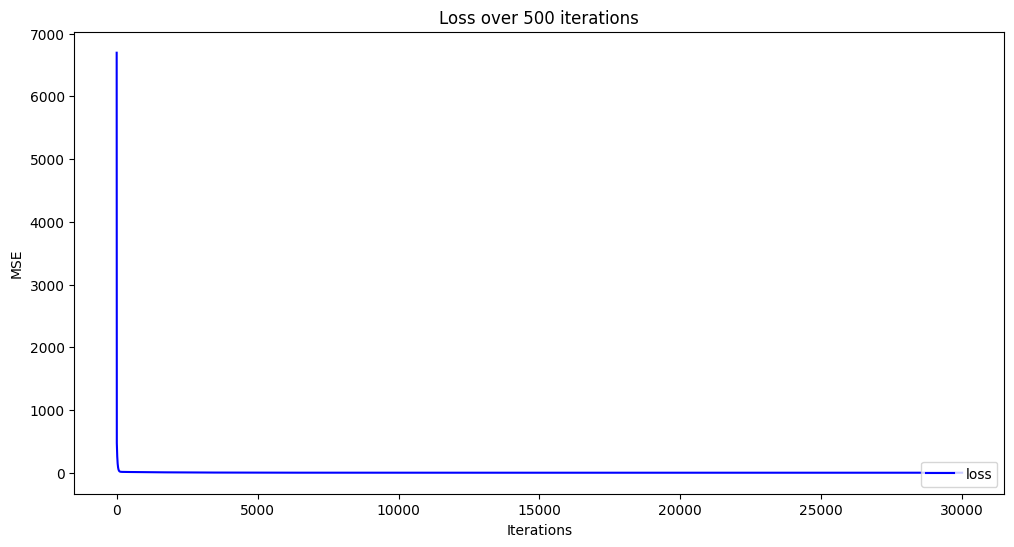

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
# plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss after about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached. This would prevent excessive training and potential over-fitting for the model.

# Things to try



1.   Change the coefficients array and try a different polynomial instead of our $x^2$.
2.   Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate?
3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of $x^2$?
4. Can you modify the algorithm to find a maxima of a function, instead of a minima?



### 1. Change the coefficients array and try a different polynomial instead of our  x2 .

In [117]:
def eval_polynomial(coeffs, x):
    """
    Function to return the output of evaluating a polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * x
    b = coeffs[1] * ( x**3 )
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-3, 3, 100)
coeffs = [1.9, -1, 0.8]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_polynomial(coeffs, x)
    xs.append(x)
    ys.append(y)

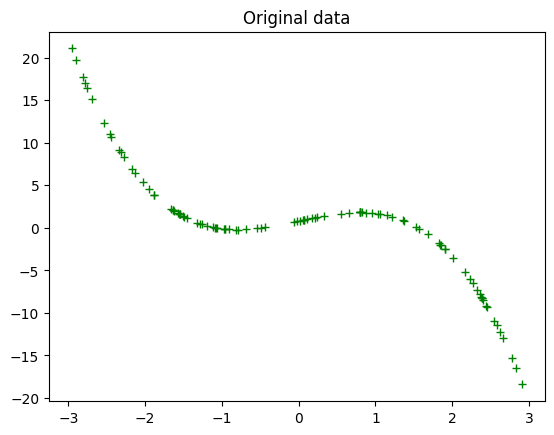

In [118]:
plt.plot(xs, ys, 'g+')
plt.title("Original data")
plt.show()

In [119]:
def eval_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * x
    b = coeffs[1] * ( x**3 )
    c = coeffs[2]
    y = a + b + c

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


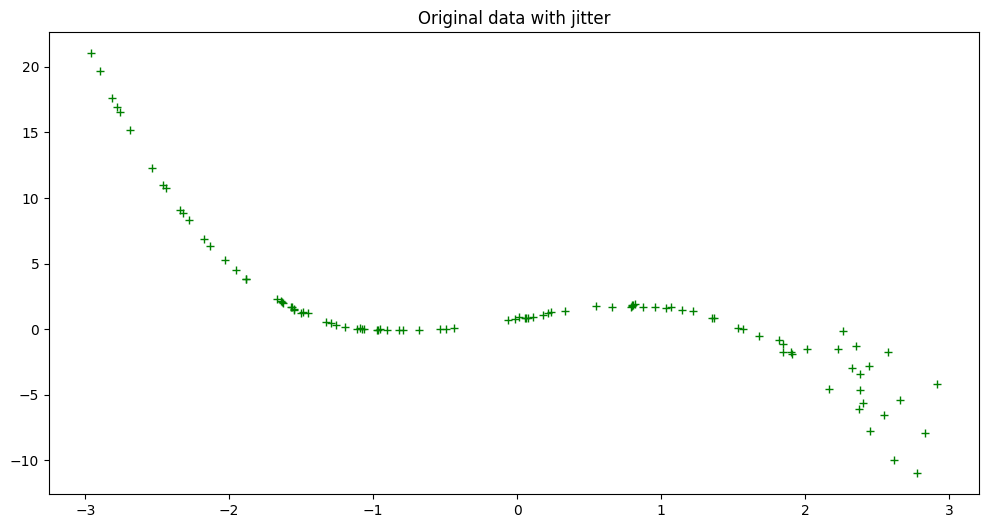

In [120]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

(-9, -3, 9)


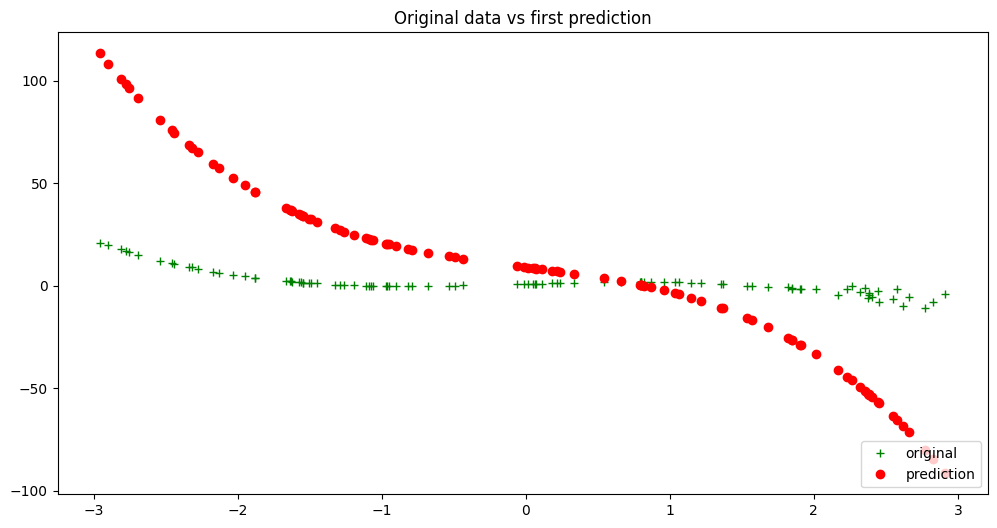

In [121]:
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))
print(rand_coeffs)
y_bar = eval_polynomial(rand_coeffs, hundred_xs)
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

In [122]:
def calc_gradient_poly(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_polynomial(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        partial_a = x * (y - y_bar)
        a_s.append(partial_a)
        partial_b = (x**3) * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_polynomial(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [123]:
def gradient_descent(epochs, lr, rand_coeffs_to_test = rand_coeffs):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    # rand_coeffs_to_test = rand_coeffs
    for i in range(epochs):
        loss = calc_gradient_poly(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

In [124]:
GD = gradient_descent(6000, 0.0007)

[1228.3896661592185, 934.4661372956303, 717.7274647453488, 557.8884930946941, 439.9953022121088, 353.0240806019171, 288.8482353442532, 241.4769606576791, 206.4939217860304, 180.64346097387516, 161.52555456692022, 147.37093985030234, 136.87534184448134, 129.0772677250278, 123.26791865719652, 118.92477811868618, 115.66265418301634, 113.19758860725875, 111.32025113964929, 109.87632619249518, 108.75205418445096, 107.86357282962548, 107.14905969188321, 106.56293979085532, 106.07161553385133, 105.65031888414838, 105.28079082551535, 104.94957069741486, 104.64673511794416, 104.36496833627909, 104.0988769100966, 103.84448449579622, 103.59885941524244, 103.35984010341326, 103.12583271242278, 102.89566190816475, 102.66846087977848, 102.44359025623557, 102.22057833282913, 101.99907700701552, 101.77882929495739, 101.55964538519312, 101.3413849857484, 101.1239443106835, 100.90724648676263, 100.69123448138926, 100.47586588917999, 100.2611090887004, 100.0469404092653, 99.83334204234083, 99.62030050185

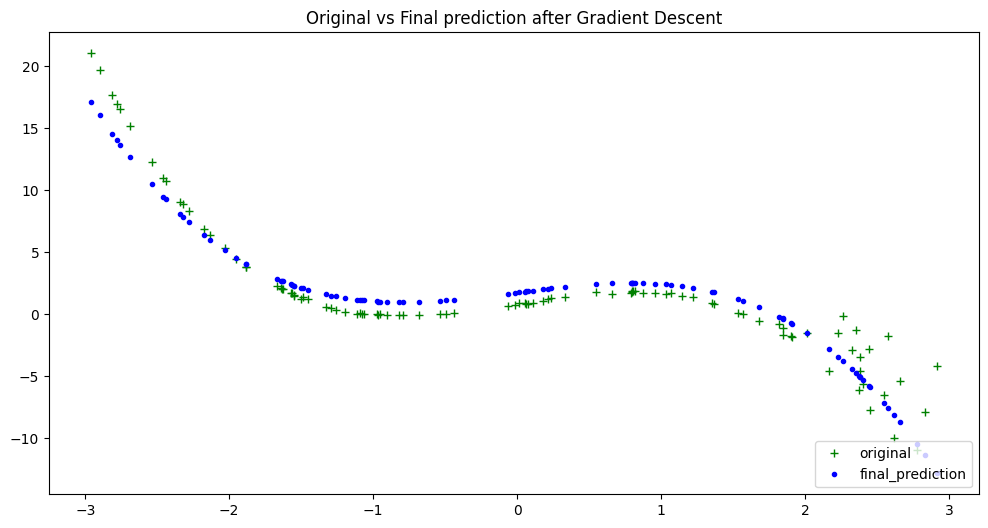

In [125]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [126]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (1.4578192177969445, -0.7604568755297764, 1.744521507315999)
Original Coefficients: [1.9, -1, 0.8]


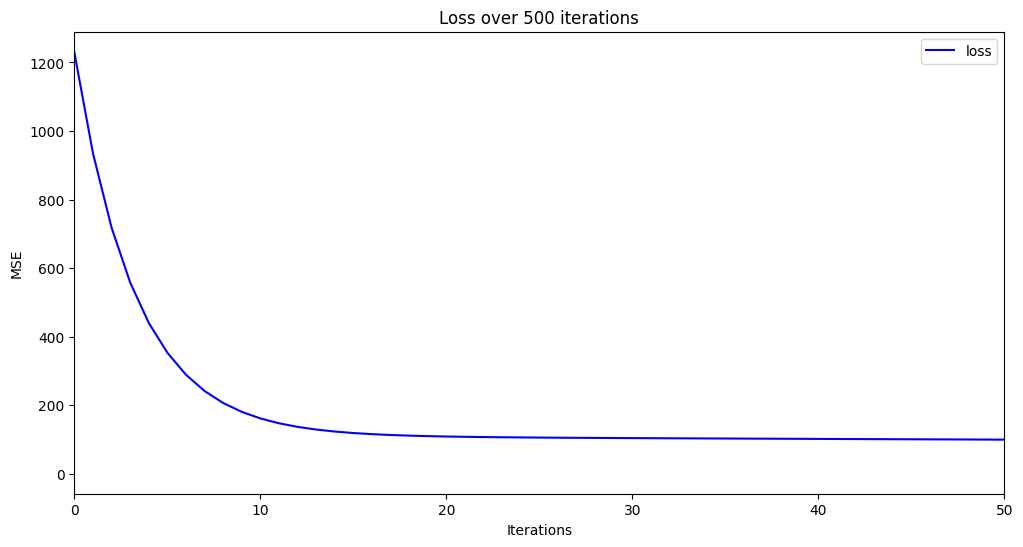

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'b-', label = 'loss')
plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="upper right")
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

It converged around 12-13 iterations

### 2. Increase/decrease the learning rate to see how many iterations will be take to coverge. Does it even converge on a huge learning rate

#### Low learning rate

In [128]:
GD = gradient_descent(7000, 0.0000007)

[1626.5861806079288, 1626.157396809721, 1625.7287341997348, 1625.3001927436987, 1624.8717724073526, 1624.4434731564452, 1624.0152949567344, 1623.587237773986, 1623.1593015739827, 1622.7314863225076, 1622.303791985361, 1621.8762185283476, 1621.4487659172837, 1621.021434117998, 1620.594223096323, 1620.167132818107, 1619.7401632492026, 1619.3133143554765, 1618.8865861028028, 1618.4599784570642, 1618.0334913841552, 1617.607124849982, 1617.180878820453, 1616.7547532614929, 1616.328748139034, 1615.9028634190179, 1615.4770990673976, 1615.051455050133, 1614.6259313331952, 1614.2005278825638, 1613.7752446642305, 1613.3500816441924, 1612.9250387884624, 1612.5001160630575, 1612.075313434004, 1611.6506308673445, 1611.2260683291236, 1610.801625785399, 1610.3773032022386, 1609.9531005457184, 1609.5290177819231, 1609.1050548769501, 1608.6812117969055, 1608.2574885079025, 1607.8338849760667, 1607.410401167532, 1606.98703704844, 1606.5637925849453, 1606.140667743211, 1605.7176624894114, 1605.2947767897

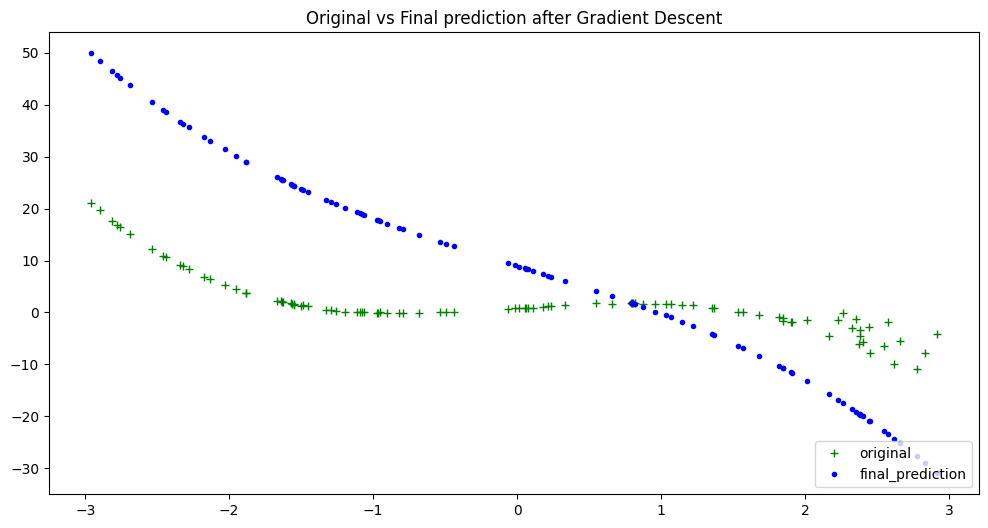

In [129]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [130]:
print(f"Error = {GD[3][-1]}")

Error = 318.8344389851594


The predictions are way off from the original data when the learning rate is too small. If we increase the number of iterations it will converge eventually.

In [131]:
GD = gradient_descent(15000, 0.0000007)

[1626.5861806079288, 1626.157396809721, 1625.7287341997348, 1625.3001927436987, 1624.8717724073526, 1624.4434731564452, 1624.0152949567344, 1623.587237773986, 1623.1593015739827, 1622.7314863225076, 1622.303791985361, 1621.8762185283476, 1621.4487659172837, 1621.021434117998, 1620.594223096323, 1620.167132818107, 1619.7401632492026, 1619.3133143554765, 1618.8865861028028, 1618.4599784570642, 1618.0334913841552, 1617.607124849982, 1617.180878820453, 1616.7547532614929, 1616.328748139034, 1615.9028634190179, 1615.4770990673976, 1615.051455050133, 1614.6259313331952, 1614.2005278825638, 1613.7752446642305, 1613.3500816441924, 1612.9250387884624, 1612.5001160630575, 1612.075313434004, 1611.6506308673445, 1611.2260683291236, 1610.801625785399, 1610.3773032022386, 1609.9531005457184, 1609.5290177819231, 1609.1050548769501, 1608.6812117969055, 1608.2574885079025, 1607.8338849760667, 1607.410401167532, 1606.98703704844, 1606.5637925849453, 1606.140667743211, 1605.7176624894114, 1605.2947767897

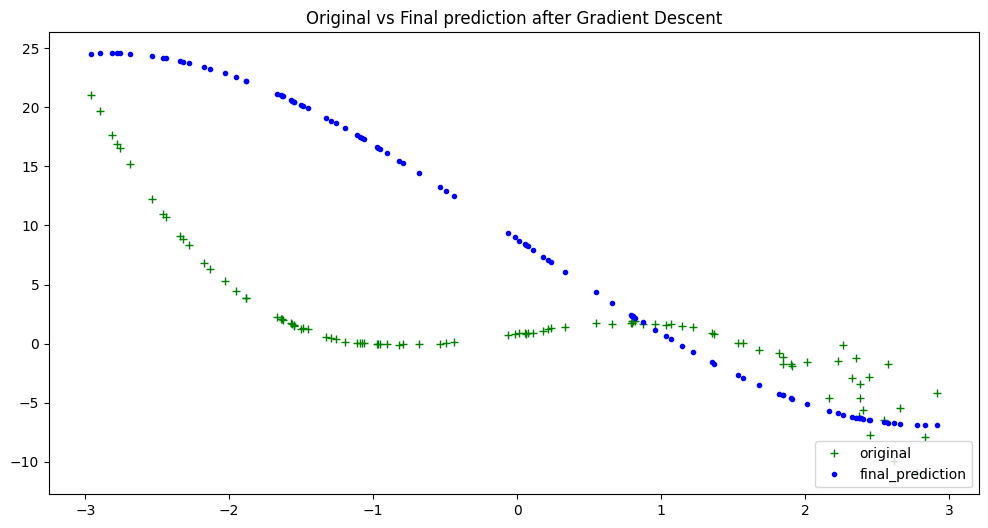

In [132]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [133]:
print(f"Error = {GD[3][-1]}")

Error = 129.41379972110647


The error has gone down significantly when we doubled the #iterations.

#### High learning rate

In [134]:
GD = gradient_descent(7000, 0.001)

[1076.1072891315896, 725.1695658521004, 501.5717393943066, 359.06344998829036, 268.192809621295, 210.2050726238101, 173.15735431011254, 149.44451259878997, 134.22364776208494, 124.41083554083696, 118.0422542263429, 113.86735512016186, 111.08979649753348, 109.20247227496071, 107.88245948815127, 106.92412162439612, 106.19650932031249, 105.61623344180805, 105.13019086239002, 104.70456436677324, 104.31781787098421, 103.95623583040721, 103.61108276785711, 103.27679448208117, 102.94982622271324, 102.62791921659574, 102.30963359715473, 101.99405097726277, 101.68058504982005, 101.36886097958408, 101.05863860075895, 100.74976350976588, 100.44213592145942, 100.13569083697485, 99.83038541473692, 99.52619092839099, 99.22308764564956, 98.92106156715838, 98.62010234980852, 98.32020198429468, 98.0213539529724, 97.72355269356616, 97.42679325764097, 97.1310710930976, 96.83638190564653, 96.54272157057343, 96.25008607653098, 95.9584714897248, 95.66787393108616, 95.37828956171461, 95.0897145735866, 94.802

If we're putting a value greater than 0.007, we are getting  RuntimeWarning: overflow encountered in double_scalars
  return sum((ys - y_bar) * (ys - y_bar)) / len(ys)

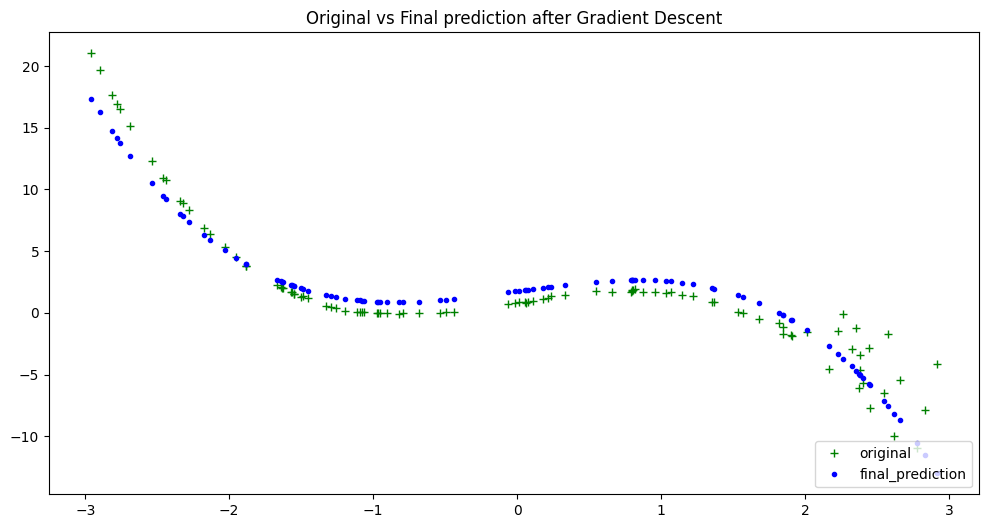

In [135]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

It is getting converged but the convergence may fail if we try higher learning rates because the gradient may shoot up and never reach the local/global minima.

### 3. Take a degree 5 polynomial with 5 roots and try different initializations, instead of random ones. Does it converge on different values for different initializations? Why does initialization not matter in our case of  x2 ?

In [136]:
def eval_polynomial(coeffs, x):

    # print(coeffs)
    a = coeffs[0] * (x**5)
    b = coeffs[1] * (x**4)
    c = coeffs[2] * (x**3)
    d = coeffs[3] * (x**2)
    e = coeffs[4] * x
    f = coeffs[5]
    y = a + b + c + d  + e + f
    return y

hundred_xs = np.random.uniform(-2, 2, 100)
coeffs = [-0.2, -3.87, 0.8, 2.32, 0, 0.34]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_polynomial(coeffs, x)
    xs.append(x)
    ys.append(y)

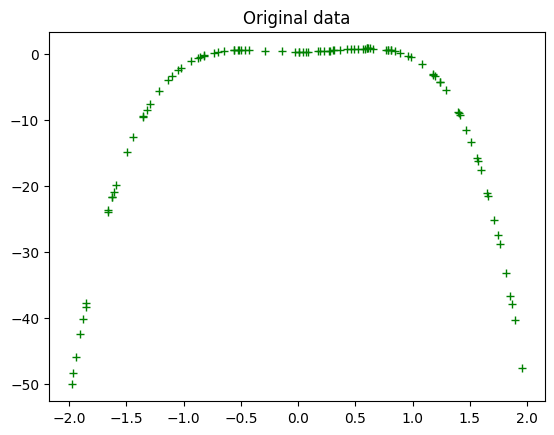

In [137]:
plt.plot(xs, ys, 'g+')
plt.title("Original data")
plt.show()

In [138]:
def eval_jitter(coeffs, x, j):

    a = coeffs[0] * (x**5)
    b = coeffs[1] * (x**4)
    c = coeffs[2] * (x**3)
    d = coeffs[3] * (x**2)
    e = coeffs[4] * x
    f = coeffs[5]
    y = a + b + c + d  + e + f

    interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max      # Generate a random number in range 0 to interval max

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)

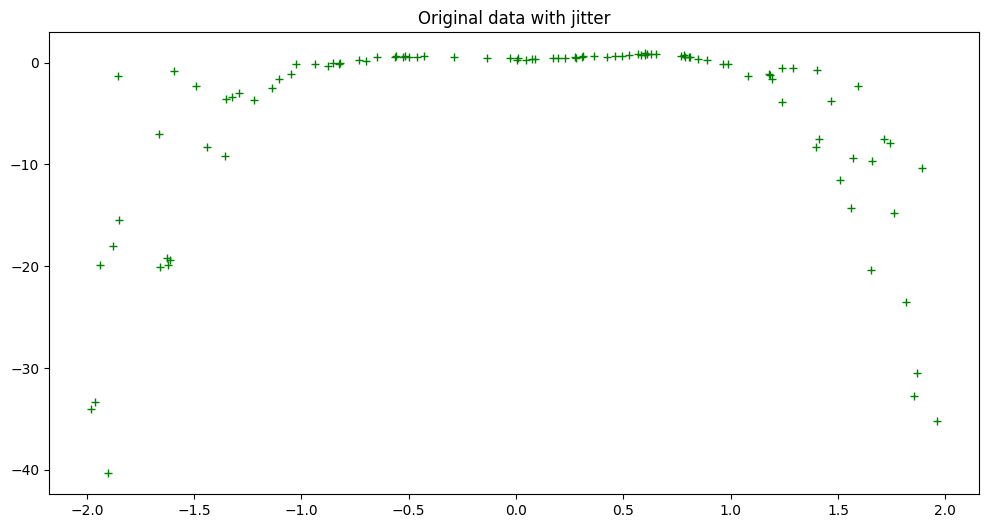

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

In [140]:
def calc_gradient_poly(coeffs, inputs_x, outputs_y, lr):
    """
    m

    """
    a_s = []
    b_s = []
    c_s = []
    d_s = []
    e_s = []
    f_s = []

    y_bars = eval_polynomial(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        partial_a = (x**5) * (y - y_bar)
        a_s.append(partial_a)
        partial_b = (x**4) * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (x**3) * (y - y_bar)
        c_s.append(partial_c)
        partial_d = (x**2) * (y - y_bar)
        d_s.append(partial_d)
        partial_e = (x) * (y - y_bar)
        e_s.append(partial_e)
        partial_f = (y - y_bar)
        f_s.append(partial_f)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)
    gradient_d = (-2 / n) * sum(d_s)
    gradient_e = (-2 / n) * sum(e_s)
    gradient_f = (-2 / n) * sum(f_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    d_new = coeffs[3] - lr * gradient_d
    e_new = coeffs[4] - lr * gradient_e
    f_new = coeffs[5] - lr * gradient_f

    new_model_coeffs = (a_new, b_new, c_new, d_new, e_new, f_new)

    # update with these new coeffs:
    new_y_bar = eval_polynomial(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [141]:
custom_coeffs = [0.23, -2.11, 0, 21, -9.1, -1]
GD = gradient_descent(6000, 0.0005, custom_coeffs)

[1263.5490889163734, 1175.6369416333248, 1096.010163437283, 1023.600400584951, 957.5192615019973, 897.023455137266, 841.4870576840316, 790.3794231852066, 743.2475645112543, 699.7020769066459, 659.405870448328, 622.0651311747658, 587.4220518794431, 555.2489693748057, 525.3436207588861, 497.52529107376336, 471.6316720635938, 447.51628915154373, 425.04638333849357, 404.1011581241507, 384.5703200606622, 366.3528561950409, 349.35600324955647, 333.4943725685381, 318.6892021313422, 304.8677126940006, 291.96254969192796, 279.9112961624105, 268.6560448255708, 258.143019751825, 248.3222398656764, 239.147217987312, 230.57469027184786, 222.56437183199992, 215.0787350715813, 208.08280785255127, 201.54398909750515, 195.43187981626738, 189.71812785853766, 184.37628494923047, 179.38167477108928, 174.71127102972298, 170.34358457682774, 166.25855878393156, 162.43747245622063, 158.86284965759307, 155.5183758870095, 152.38882010483874, 149.45996215810567, 146.718525196862, 144.15211271151108, 141.74914985

In [142]:
coeffs

[-0.2, -3.87, 0.8, 2.32, 0, 0.34]

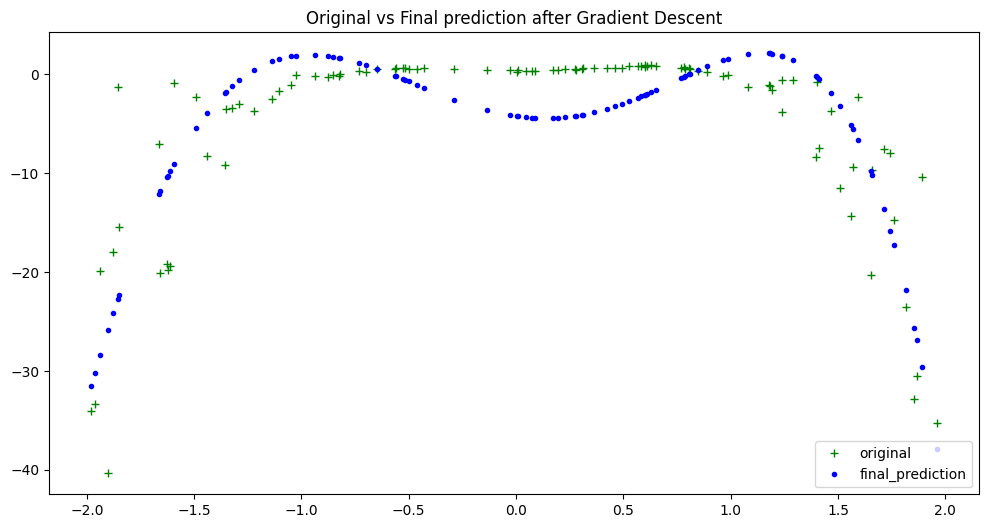

In [143]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [144]:
print(f"Error = {GD[3][-1]}")

Error = 29.664949049323205


In [145]:
custom_coeffs = [-1.34, -24, 2.112, -0.3423, 9.432, -42]
GD = gradient_descent(6000, 0.0005, custom_coeffs)

[21632.92791149897, 20208.90716844025, 18889.80706756805, 17666.417625632417, 16530.61487791248, 15475.188886000244, 14493.704160467698, 13580.385935111777, 12730.027091880738, 11937.911612887998, 11199.75128793263, 10511.63307992725, 9869.975083916746, 9271.48943745338, 8713.15087427803, 8192.16987795803, 7705.969601895858, 7252.16588844697, 6828.5498518521035, 6433.0725944781325, 6063.831709145298, 5719.059286580616, 5397.111199822322, 5096.457479509646, 4815.673627641256, 4553.432744326102, 4308.498363667811, 4079.7179123134383, 3866.0167182274304, 3666.3925086077775, 3479.9103450875623, 3305.69795189154, 3142.9413987857693, 2990.881105738754, 2848.8081404200366, 2716.060783167307, 2592.021336991113, 2476.1131626654537, 2367.797921058539, 2266.5730066595193, 2171.96915780899, 2083.5482304872303, 2000.9011236899003, 1923.645845454578, 1851.425709515996, 1783.9076533816967, 1720.7806693481489, 1661.7543406324749, 1606.557475386919, 1554.9368319003936, 1506.655928780751, 1461.493934358

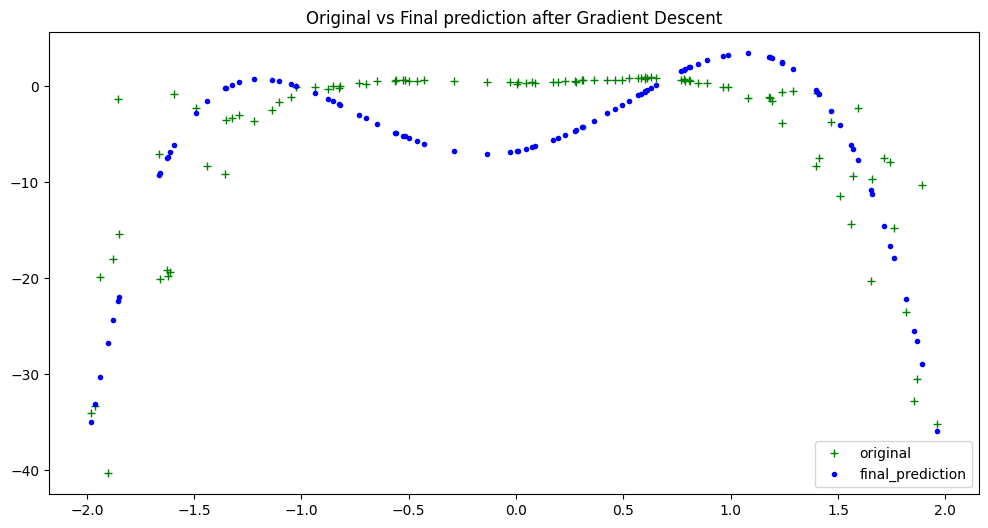

In [146]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [147]:
print(f"Error = {GD[3][-1]}")

Error = 36.75695409779693


As the x^2 polynomial is a simple equation, there are less number of roots and it's less complex so the initialization does not matter. But in the above case there are 5 roots which is making it complex for the algorithm to learn.

### 4. Can you modify the algorithm to find a maxima of a function, instead of a minima?

#### Gradient ascent

$$w^{k+1} \leftarrow w^k + \eta \Delta J$$

* Used when we are having a concave function
* Used to find maxima

In [148]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    ########################################################################
    # Modification:
    a_new = coeffs[0] + lr * gradient_a
    b_new = coeffs[1] + lr * gradient_b
    c_new = coeffs[2] + lr * gradient_c
    ########################################################################

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar